The following program addresses a common **Constraint Satisfaction Problem** by solving the game Sudoku (shown below) using backtracking principles.
In addition, following the main algoritm, we perform some data visualization/analysis.

![Solved Sudoku](img/solved.png)

The general program design begins with creating classes for both **Blanks** and **Boards**. A blank is each individual tile not filled in and a Board is comprised of both constants already filled in and Blank objects

In [98]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import random
import copy
from tqdm import tqdm

Below is the Blank class outlining Blank objects. First, the blank establishes basic info passed through parameters such as its index on the board and all of the rows, columns, and groups of the board which are each lists containing lists of numbers 1-9 or 0's representing a blank. The Blank uses its index to determine which row, column, and group is *its own*. For rows we can simply do integer division by 9 on the index describing its space in the 9x9 grid. Columns is simply a modulo of the index with 9. Its specific group is slightly more complicated so there is a helper method to determine that.

Once the Blank knows which row, column, and group it is a part of we can run the most important method whih is the **find_possibilities** method. This method iterates through numbers 1-9 and checks to see if they are present in either its row, column, or group already. The **continue** keyword just means go back up to the top of the loop and start the next iteration. So this method will only reach the append statement if the number is in none of these already. This means its a valid posibility and thus should be added to the **possibles list**. In the end, this list will comprise each number that is a valid move for the Blank which makes the program much more efficient than trying a new board filled with each number 1-9 and checking if it is a valid move.

In [99]:
class Blank():
    
    def __init__(self, index, board, rows, columns, groups):
        self.index = index
        self.value = board[index]
        self.board = board
        self.row = rows[int(index/9)]
        self.column = columns[index%9]
        self.group = groups[self.group_index()]
        self.possibles = self.find_possibles()
        
    def find_possibles(self):
        possibilities = []
        for num in range(1,10):
            if num in self.row:
                continue
            if num in self.column:
                continue
            if num in self.group:
                continue
            possibilities.append(num)
            
        return possibilities
    
    def group_index(self):
        row = int(self.index/9)
        row = int(row/3)
        grouping = int((self.index%9)/3)
        return row*3+grouping

The next cell is the Board class which is given a single paramter of *board* which is a list of 81 elements (9x9 grid). Based off of the board, methods are run to return lists of every row, column, and group in the board. These lists contain lists within them of numbers 1-9 or a 0 representing a blank. For example, *self.row[0][0]* would return the first number of the first row of the board. Then, the important **get_blanks** method is run where the program iterates through each number of the board and determines if it is filled and is constant or if it is a zero representing a blank. If it is zero, a Blank object is instantiated and added to the **blanks** list which contains each blank for the Board.

Another very important method is the **best_child** method. In this method, the list of all blanks is sorted so that the blanks with the least number of possibilities in their *possibles list* are first. The first element of this list is selected to be the **chosen blank**. Then, random is used to randomly pop an item from the list and make a new board with that number (as opposed to a 0) filled in. Then, a Board object given this board as a parameter is returned. This returned object represents a state one move ahead of the parent. The logic is similar to that of how a human solves a sudoku. If a certain space only has 1 or 2 valid options instead of something like 5 or 6, it is much easier and more efficient to start with that because there will be less branching and fewer interations. 

In [100]:
class Board():
    
    def __init__(self, board):
        self.board = board
        self.rows = self.rows()
        self.columns = self.columns()
        self.groups = self.groups()
        self.blanks = self.get_blanks()
        self.num_blanks = self.count_blanks()
        
    def count_blanks(self):
        num_blanks = 0
        for box in self.board:
            if int(box) == 0:
                num_blanks += 1
        return num_blanks
    
    def get_blanks(self):
        blanks = []
        for num in range(81):
            if int(self.board[num]) == 0:
                blanks.append(Blank(num, self.board, self.rows, self.columns, self.groups))
        return blanks
    
    def columns(self):
        columns = []
        for num in range(9):
            columns.append([0]*9)
        for row_ in range(9):
            for column_ in range(9):
                index = row_*9 + column_
                num = self.board[index]
                columns[column_][row_] = int(num)
        return columns
    
    def rows(self):
        rows = []
        for row_ in range(9):
            row = []
            for column_ in range(9):
                index = row_*9 + column_
                row.append(int(self.board[index]))
            rows.append(row)
        return rows
    
    def best_child(self):
        best = sorted(self.blanks, key = lambda x: len(x.possibles))[0]
        random_choice = random.randint(0, len(best.possibles)-1)
        value = best.possibles.pop(random_choice)
        new_board = copy.deepcopy(self.board)
        new_board[best.index] = value
        
        return Board(new_board)
    
    def groups(self):
        groups = []
        rows = self.rows
        
        for num in range(9):
            groups.append([])
        
        for num2 in range(9):
            for index_ in range(9):
                group_num = int(index_/3)
                group_num2 = int(num2/3)
                groups[group_num+group_num2*3].append(self.board[num2*9+index_])
        
        return groups
                
    def __str__(self):
        s = ''
        for row in range(9):
            if row % 3 == 0 and row != 0:
                s += '\n'
            for column in range(9):
                if column % 3 == 0 and column != 0:
                    s += '   '
                index = row*9+column
                num = self.board[index]
                s += str(num)
                s += '   '
            s += '\n'
        return s
    
    def __eq__(self, other):
        return self.board == other.board

The **check_failed** method determines if a Board object has any blanks with no valid moves. This could happen after a random value is selected from the list of possibles and a child is created. While that move itself may have been valid, it made it so that another blank now has no moves which means it must have been an incorrect choice.

In [101]:
def check_failed(Board):
    for blank in Board.blanks:
        if len(blank.possibles) == 0:
            return True
    return False

This is an **expert** puzzle from the sudoku website. the string split() method creates a list of every number passed into it as a string and casts them to int. So the test list is a list of 81 numbers representing a 9x9 sudoku puzzle.

In [102]:
test_s = '''
5 0 0 0 0 0 0 0 0
3 4 0 1 0 0 0 0 7
0 9 0 0 0 6 0 0 0
6 0 0 0 2 0 0 0 9
0 0 4 9 8 0 1 0 0
0 1 0 0 4 0 0 0 0
0 0 0 0 0 3 0 2 6
0 0 0 0 0 0 8 0 0
9 0 0 0 0 0 3 4 0
'''
test = [int(x) for x in test_s.split()]

The **solve** takes a puzzle (list of 81 numbers) and solves it. First, it instantiates the initial board using the puzzle paramter that was passed. It then creates lists for unvisited, meaning children that still have possibilities, and failed, meaning those states are unsolvable and thus a mistake along the way was made in selecting numbers for blanks.

After the initial Board is appended to unvisited, a While loop begins that would be infite if not for the break statement when the puzzle is solved. First, it sorts the unvisited list, which will soon be populated with a large number of Board objects, by the number of blanks for that puzzle. So, as a certain way of solving the puzzle continues to progress and thus less and less blanks are present, that puzzle will continually be used as a parent. This way, our most promising options are exhausted first. This sort, as well as the way blanks are sorted within the puzzle by their number of posssibilities, is essential to program efficiency. Picking a random puzzle and then picking a random blank within that puzzle would take a massive amount of time, but by prioritizing parents who are closed to being solved and blanks within those parents that are easiest, efficiency is much better. 

After the best parent is selected and it is determined that it is a valid Board, a child is created. As long as the child is determined to be **not** *failed*, it is added to the unvisited list and the process repeats. This continues until the number of blanks of our best parent is 0 meaning we have filled in every blank in a valid manner. The program then prints the solved puzzle and breaks out of the loop.

In [103]:
def solve(puzzle):
    initial = Board(puzzle)
    unvisited = []
    failed = []
    unvisited.append(initial)
    print(f'Start\n{unvisited[0]}')
    
    while(True):
        unvisited = sorted(unvisited, key = lambda x : x.num_blanks)
        best = unvisited[0]    

        if check_failed(best):
            failed.append(unvisited.pop(0))
            continue

        if best.num_blanks == 0:
            print('The Puzzle has been solved!\n')
            print(best)
            return (best, failed, unvisited)
            break

        child = best.best_child()

        if check_failed(child):
            failed.append(child)
        elif child not in unvisited:
            unvisited.append(child)

Below is a timed example solving the expert puzzle.
**Note:** This puzzle is an illustration of an expert puzzle, most puzzles are solved much quicker than this one.

In [104]:
%%time
best, failed, unvisited = solve(test)

Start
5   0   0      0   0   0      0   0   0   
3   4   0      1   0   0      0   0   7   
0   9   0      0   0   6      0   0   0   

6   0   0      0   2   0      0   0   9   
0   0   4      9   8   0      1   0   0   
0   1   0      0   4   0      0   0   0   

0   0   0      0   0   3      0   2   6   
0   0   0      0   0   0      8   0   0   
9   0   0      0   0   0      3   4   0   

The Puzzle has been solved!

5   6   8      2   7   4      9   1   3   
3   4   2      1   5   9      6   8   7   
1   9   7      8   3   6      2   5   4   

6   8   5      3   2   1      4   7   9   
7   3   4      9   8   5      1   6   2   
2   1   9      6   4   7      5   3   8   

8   5   1      4   9   3      7   2   6   
4   7   3      5   6   2      8   9   1   
9   2   6      7   1   8      3   4   5   

CPU times: user 2.81 s, sys: 76.1 ms, total: 2.89 s
Wall time: 3.41 s


In [105]:
failed_blank = sorted(failed[0].blanks, key = lambda x : len(x.possibles))[0]

In [106]:
print(failed_blank.index)

60


In [107]:
print(failed[0])

5   7   1      8   3   9      4   6   2   
3   4   6      1   5   2      9   8   7   
8   9   2      4   7   6      5   1   3   

6   0   0      3   2   1      7   0   9   
2   0   4      9   8   7      1   0   0   
7   1   0      6   4   5      2   3   0   

0   0   0      0   0   3      0   2   6   
0   0   0      0   0   0      8   0   0   
9   0   0      0   0   0      3   4   0   



Now that we have succcessfully created an algorithm to solve the Constraint Satisfaction Problem of Sudoku, we can do some data analysis by randomly generating and solving a large number of puzzles.

The **quiet_solve** method is the exact same logic as solve without the print statement so it an be run in a loop without massive output. 

It returns a tuple containing the best Object, the failed list, and the unvisited list.

In [108]:
def quiet_solve(puzzle):
    initial = Board(puzzle)
    unvisited = []
    failed = []
    unvisited.append(initial)
    
    while(True):
        unvisited = sorted(unvisited, key = lambda x : x.num_blanks)
        best = unvisited[0]    

        if check_failed(best):
            failed.append(unvisited.pop(0))
            continue

        if best.num_blanks == 0:
            return(best, failed, unvisited)
            break

        child = best.best_child()

        if check_failed(child):
            failed.append(child)
        elif child not in unvisited:
            unvisited.append(child)

The following two methods are used in our generation of random solvable puzzles. Originally, I thought this process would be arduos considering you have to ensure that every time you are putting a number to create a puzzle it is still valid and not interfering with the members of its row, column, and group. Thinking through it however, I realized that we had already made this procecss happen in our solve method. **All the program needs to generate a random puzzle (completely filled in) is to call the solve method but instead of passing a puzzle to solve we pass a list of 81 0's signifying a blank board**. Due to the element of random choice in our logic for selecting possibilities, this will continually fill in blanks with random choices but they will always be valid because it is selecting from only a list of valid choices. So, a seemingly long proecss takes only 2 lines.

After we generate a random puzzle with every number filled in, the **encrypt method** is run to take out a certain amount of numbers and replace them with blanks since the puzzle is not very fun if it is already solved. This method leaves a random number between 41 and 71 blanks to be filled. The min of 41 and max of 71 can be altered if desired. It is in place beause the vast majority of sudoku puzzles are in this range and otherwise you may be solving some pretty useless sudokus like some that have only one value filled in or every valued filled but 2 for example.

In [113]:
def encrypt(full):
    new_board = copy.deepcopy(full.board)
    num_to_erase = 81-random.randint(10,40)
    for _ in range(num_to_erase):
        to_erase = 0
        random_index = 0
        while(to_erase == 0):
            random_index = random.randint(0,80)
            to_erase = new_board[random_index]
        new_board[random_index] = 0
    return Board(new_board)

In [114]:
def generate_puzzle():
    blank_board = [0]*81
    best, failed, unvisited = quiet_solve(blank_board)
    return encrypt(best)

The **get_enigma** method returns the enigma value of a board. The enigma value of a board is the sum of the length of all possible values for each blank. Essentially, it is a metric to compare board complexity (to a degree). For example, if we had only 2 blanks each with 3 possibilities, our total enigma would be 6. In pratie our enigma score will be far higher.

In [115]:
def get_enigma(board):
    total = 0
    for blank in board.blanks:
        total += len(blank.possibles)
    return total

The **given** method returns the number of given values of a board. These are **not** values already filled in but instead are blanks on the board that have only one possibility. In this way they are not filled in but they are **given** since they require very minimal computing.

In [116]:
def given(board):
    total = 0
    for blank in board.blanks:
        if len(blank.possibles) == 1:
            total += 1
    return total

The **get_puzzle_info** method takes an intial puzzle and computes metrics such as the number of blanks, enigma value, number of given values. In addition, it computes the max_in_row, max_in_column, and max_in_group values. Each of these are the same concept which is that the value is computed by finding the number of filled tiles in each row group or column and then returns the maximum for each structure of row, group, and column. In this way, it can be another metric for board complexity. 

In [117]:
def get_puzzle_info(p):
    num_blank = p.num_blanks
    enigma_val = get_enigma(p)
    given_tiles = given(p)
    
    max_in_row = 0
    max_in_column = 0
    max_in_group = 0
       
    for row in p.rows:
        num = 0
        for tile in row:
            if tile == 0:
                continue
            else:
                num += 1
        if num > max_in_row:
            max_in_row = num
    
    
    for column in p.columns:
        num = 0
        for tile in column:     
            if tile == 0:
                continue
            else:
                num += 1
        if num > max_in_column:
            max_in_column = num
        
    for group in p.groups:
        num = 0
        for tile in group:
            if tile == 0:
                continue
            else:
                num += 1
    if num > max_in_group:
        max_in_group = num
    
    return (num_blank, enigma_val, given_tiles, max_in_row, max_in_column, max_in_group)

The following code cells were run initially to generate a Pandas Dataframe containg information about over 2000 randomly generated puzzles. The puzzles were then solved and the time to solve them was computed. In the end, the dataframe has info about each calculate metric of a puzzle and its time to solve which can help us visualize what exactly makes a Sudoku puzzle difficult. Feel free to change these cells back to code and run them but you may want to break out of the loop as it takes quite a bit for the loop to finish since it is such a large number of puzzles to solve with the possibility of edge cases that take longer due to random generation.

After running the previous cells, I stored the dataframe in a pickle file so it can be read in without having to re-run the trials again. The dataframe contains every trial that was not an outlier. Outliers were anything that is a statistical outlier meaning $median(T) + 2*IQR(T) < T_i$ or $median(T) - 2*IQR(T) > T_i$ where $T$ is the distribution of all elapsed times and $T_i$ is the time for a given puzzle We will name the dataframe with a highly original *df*

In [118]:
df = pd.read_pickle('solve_data')

In [119]:
df.set_index('index', inplace = True)

In [120]:
df.head()

,Elapsed_Time,Number_of_Fails,Number_of_Blanks,Total_Enigma,Given,Max_in_Row,Max_in_Column,Max_in_Group
index,,,,,,,,
1,0.044927,11,71,477,0,4,2,1
3,0.032063,3,63,319,0,4,4,1
4,0.031230,0,71,474,0,4,3,0
5,0.052269,63,57,260,0,5,5,1
6,0.041614,18,68,407,0,4,3,1


In [121]:
len(df)

2036

The describe method gives us some numbers on whichever column we pass or the entire dataframe if desired. Here it is breaking down all 2036 of our elapsed times.

In [122]:
df['Elapsed_Time'].describe()

count    2036.000000
mean        0.027937
std         0.009972
min         0.012203
25%         0.019671
50%         0.027242
75%         0.033993
max         0.061513
Name: Elapsed_Time, dtype: float64

The following plot shows us the distribution of the number of blanks for each of our 2036 puzzles.

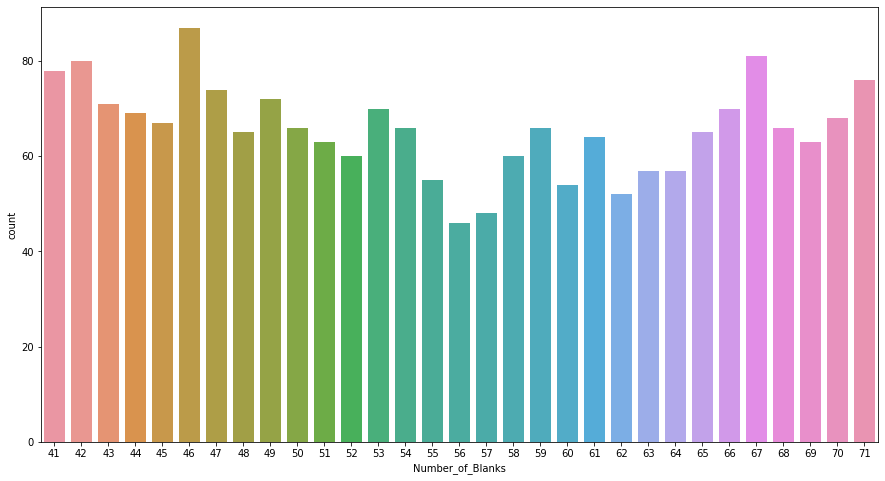

In [123]:
fig = plt.figure(figsize = (15, 8))
sns.countplot(df['Number_of_Blanks'])

The following plot shows the trend downwards of time when compared to the number of given values. **This clues us in that their may be good ways to estimate time with certain easily computable metrics.**

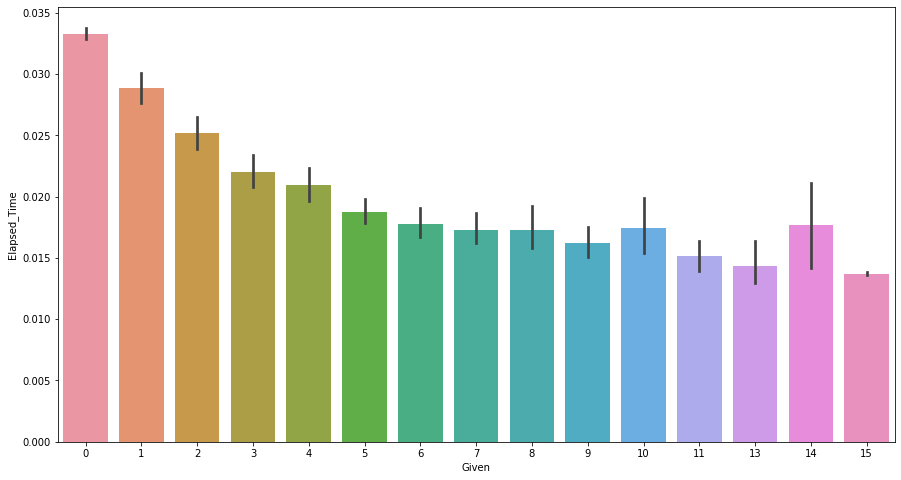

In [124]:
fig = plt.figure(figsize = (15, 8))
sns.barplot(x = df['Given'], y = df['Elapsed_Time'])

The following is a **Heatmap** showing the coorelation between each column of the dataframe. The important row to look at is the first one which shows how each metric coorelates to elapsed_time. We see a relatively **direct** coorelation between elapsed_time and metrics like number_of_blanks meaning more blanks more time to solve whereas there appears to be an **inverse** coorelation between things like Max_in_Row and elapsed_time meaning the more in a row the easier a puzzle is to solve. Both of these findings are logical if we think about the way in which Sudoku is solved.

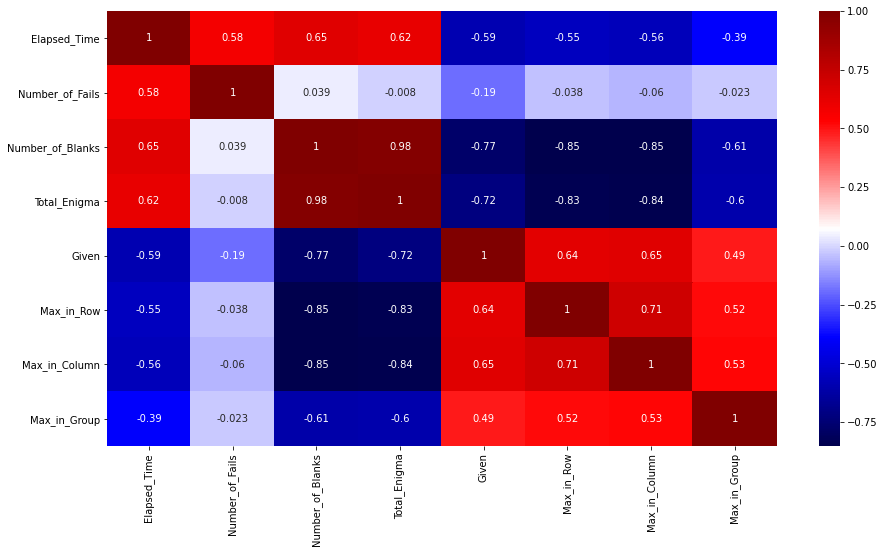

In [125]:
fig = plt.figure(figsize = (15, 8))
sns.heatmap(df.corr(), cmap = 'seismic', annot = True)

Our next interesting task is something a website like sudoku.com may be faced with. Generating large amounts of random puzzles for users to solve. However, how should we determine the difficulty of these? We ccould solve them with the computer and track the amount of time that takes. However, especially as the number of puzzles needed grows immensely, solving each one would be ardous. Instead, we can use the information we have between the relationship of easily calcuclated metrics and the time it takes to solve a puzzle. We can create a linear regression model to look at a puzzle and determine how long it **thinks** it will take to solve as opposed to actually having to solve it. Will this be that much more efficient, however? Let's find out...

ML Model

In [126]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

First, we are going to make **X** the seletion of our dataframe we want the model to know before guessing. This includes the metrics like number_of_blanks, enigma, max_in_row, etc.

In [127]:
X = df.drop(['Elapsed_Time', 'Number_of_Fails'], axis = 1)
X.head()

,Number_of_Blanks,Total_Enigma,Given,Max_in_Row,Max_in_Column,Max_in_Group
index,,,,,,
1,71,477,0,4,2,1
3,63,319,0,4,4,1
4,71,474,0,4,3,0
5,57,260,0,5,5,1
6,68,407,0,4,3,1


Then we will make **y** the column we want the model to predit based off of **X**. 

In [128]:
y = df['Elapsed_Time']
y.head()

index
1    0.044927
3    0.032063
4    0.031230
5    0.052269
6    0.041614
Name: Elapsed_Time, dtype: float64

**train_test_split** takes our X and y and randomly splits it into batches of training and test data. We use tuple unpacking to store each of them under the proper name. In this case, we chose to use 1/3 of the data as test (2/3 as training).

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [130]:
model = LinearRegression()

Here we see the beauty of sklearn. It is important to know what is going on behind the scenes of linear regression to be more effective in ML/AI. However, all it takes is one line of code to fit a model to data.

In [131]:
%%time
model.fit(X_train, y_train)

CPU times: user 4.2 ms, sys: 781 µs, total: 4.98 ms
Wall time: 5.71 ms


LinearRegression()

The formula for linear regression is:
$Y = B_0 + B_1*X_1 + B_2*X_2 + B_3*X_3...etc$ where $B_0$ is a constant, $B_i$ is a coefficcient and $X_i$ is a puzzle metric 

In the cell below, we can print the coefficients assoiated with each value. Essentially, the model is adjusting coefficients and constants so that when puzzle values are entered into the formula, the predicted Y value is extremely close to the actual Y. It is hard to tell as humans what these coefficients really mean but still cool to see.

In [132]:
print(model.coef_)

[ 1.16346600e-03 -5.10911169e-05 -5.95666308e-04 -1.43188833e-04
 -2.94746671e-04  2.86180052e-04]


We will know use our trained model to predict how long a puzzle will take to solve without having to solve it.

In [133]:
%%time
predictions = model.predict(X_test)

CPU times: user 2.87 ms, sys: 66 µs, total: 2.94 ms
Wall time: 3.04 ms


The following is a scatterplot showing the atual value on the x-axis compared to the predicted value on the Y. As we an see, the model is pretty acccurate.

Text(0, 0.5, 'Predicted Y')

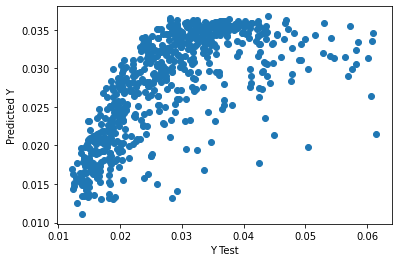

In [134]:
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

Another thing we can use is metrics from sklearn to show error. Our Mean Absolute Error is around .005 seconds

In [135]:
# calculate accuracy metrics for time prediction
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, predictions))

MAE: 0.005257761912290874


The code block below is creating 250 random puzzles and adding them and their metrics to a dataframe

In [136]:
%%time
num_blanks = []
enigmas = []
given_tiles = []
max_in_rows = []
max_in_columns = []
max_in_groups = []
puzzle_list = []
for i in tqdm(range(250)):
    p = generate_puzzle()
    puzzle_list.append(p)

    num_blank, enigma, given_tile_num, max_in_row, max_in_column, max_in_group = get_puzzle_info(p)
    num_blanks.append(num_blank)
    enigmas.append(enigma)
    given_tiles.append(given_tile_num)
    max_in_rows.append(max_in_row)
    max_in_columns.append(max_in_column)
    max_in_groups.append(max_in_group)

100%|██████████| 250/250 [00:18<00:00, 13.68it/s]

CPU times: user 15.9 s, sys: 269 ms, total: 16.1 s
Wall time: 18.3 s


In [137]:
enigma_df = pd.DataFrame(enigmas)
blanks_df = pd.DataFrame(num_blanks)
given_df = pd.DataFrame(given_tiles)
max_row_df = pd.DataFrame(max_in_rows)
max_column_df = pd.DataFrame(max_in_columns)
max_group_df = pd.DataFrame(max_in_groups)
puzzles_df = pd.DataFrame(puzzle_list, columns = ['Puzzle'])
puzzles_df['Number_of_Blanks'] = blanks_df
puzzles_df['Total_Enigma'] = enigma_df
puzzles_df['Given'] = given_df
puzzles_df['Max_in_Row'] = max_row_df
puzzles_df['Max_in_Column'] = max_column_df
puzzles_df['Max_in_Group'] = max_group_df

In [139]:
puzzles_df.head(5)

,Puzzle,Number_of_Blanks,Total_Enigma,Given,Max_in_Row,Max_in_Column,Max_in_Group
0,0 5 0 0 2 0 0 0 0 \n0 ...,55,229,0,4,5,3
1,0 0 0 0 0 0 0 0 0 \n7 ...,58,257,1,5,6,2
2,8 0 0 0 5 9 0 4 0 \n0 ...,53,202,0,6,5,4
3,4 0 2 5 0 0 3 9 6 \n3 ...,42,102,8,6,8,4
4,6 0 4 0 0 0 9 0 0 \n0 ...,70,458,0,3,4,1


**Feel free to break out of the loop below.** It is iterating through each of the 250 radomly generated puzzles and solving them. This is meant to show how classification of difficulty would be if we had to solve each puzzle. As you can see, it is not *slow* but especially as numbers increased it would take quite a bit of time.

In [ ]:
for puzzle in tqdm(puzzles_df['Puzzle'].to_list()):
    quiet_solve(puzzle.board)

Instead lets see how long our model will take to predict elapsed times for each of our randomly generated puzzles.

In [141]:
%%time
predicted_times = model.predict(puzzles_df.drop('Puzzle', axis = 1))

CPU times: user 4.8 ms, sys: 400 µs, total: 5.2 ms
Wall time: 5.01 ms


The model is extremely fast and far outpaces solving each one individually. While it may not be quite as accurate as solving them, in this case, the lost accuracy is minimal and has minimal effect on our result whereas the gained time is signifigant.

In [142]:
puzzles_df['predicted_time'] = pd.DataFrame(predicted_times)

Now, we will use our times in the dataframe to determine the difficulty of a puzzle. The cell below determines the 33rd percentile and 66th percentile. If a predicted elapsed_time for a puzzle is less than the 33rd it is marked as easy, if it is greter than 33rd but less than 66th it is considered medium, and greater than 66th is considered hard. We then add these values in the dataframe to see it visually.

In [143]:
easy_cutoff = puzzles_df['predicted_time'].quantile(.33)
medium_cutoff = puzzles_df['predicted_time'].quantile(.66)
difficulties = []

for index, row in puzzles_df.iterrows():
    if row['predicted_time'] < easy_cutoff:
        difficulties.append('Easy')
    elif row['predicted_time'] < medium_cutoff:
        difficulties.append('Medium')
    else:
        difficulties.append('Hard')
puzzles_df['Difficulty'] = pd.DataFrame(difficulties)

In [146]:
puzzles_df.head(30)

,Puzzle,Number_of_Blanks,Total_Enigma,Given,Max_in_Row,Max_in_Column,Max_in_Group,predicted_time,Difficulty
0,0 5 0 0 2 0 0 0 0 \n0 ...,55,229,0,4,5,3,0.029461,Medium
1,0 0 0 0 0 0 0 0 0 \n7 ...,58,257,1,5,6,2,0.030201,Medium
2,8 0 0 0 5 9 0 4 0 \n0 ...,53,202,0,6,5,4,0.028514,Medium
3,4 0 2 5 0 0 3 9 6 \n3 ...,42,102,8,6,8,4,0.015175,Easy
4,6 0 4 0 0 0 9 0 0 \n0 ...,70,458,0,3,4,1,0.035079,Hard
5,6 9 0 4 0 5 8 2 0 \n0 ...,46,141,2,6,6,4,0.022000,Easy
6,4 0 0 0 0 0 0 2 0 \n0 ...,61,312,0,5,4,2,0.032067,Medium
7,8 0 0 3 0 9 0 0 0 \n3 ...,54,213,0,5,6,5,0.029250,Medium
8,6 0 2 0 3 0 0 0 8 \n3 ...,47,153,1,5,5,1,0.022725,Easy
9,5 0 0 6 4 0 1 7 8 \n0 ...,50,167,1,6,5,5,0.026502,Medium


And there we have it! 250 randomly generated puzzles classified by their difficulty without having to solve any of them. Thank you for making it to the end of this notebook. I hope you enjoyed.

In [ ]:
solve(puzzles_df.iloc[1]['Puzzle'].board)